In [ ]:
!apt install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [1]:
%%writefile vector_add.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void vectorAdd(float *a, float *b, float *c, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i == 0) printf("Thread 0: blockIdx.x = %d, blockDim.x = %d, threadIdx.x = %d\n", blockIdx.x, blockDim.x, threadIdx.x);
    if (i < n) {
        c[i] = a[i] + b[i];
        if (i == 0) printf("Kernel running: c[0] = %f\n", c[i]);
    }
}

void checkCudaError(cudaError_t err, const char *msg) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s: %s\n", msg, cudaGetErrorString(err));
        exit(1);
    }
}

int main() {
    int n = 1 << 20; // 1 million elements
    size_t size = n * sizeof(float);

    float *h_a = (float*)malloc(size);
    float *h_b = (float*)malloc(size);
    float *h_c = (float*)malloc(size);

    for (int i = 0; i < n; i++) {
        h_a[i] = rand() / (float)RAND_MAX;
        h_b[i] = rand() / (float)RAND_MAX;
    }
    printf("h_a[0] = %f, h_b[0] = %f\n", h_a[0], h_b[0]);

    float *d_a, *d_b, *d_c;
    checkCudaError(cudaMalloc(&d_a, size), "cudaMalloc d_a failed");
    checkCudaError(cudaMalloc(&d_b, size), "cudaMalloc d_b failed");
    checkCudaError(cudaMalloc(&d_c, size), "cudaMalloc d_c failed");

    checkCudaError(cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice), "Copy to d_a failed");
    checkCudaError(cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice), "Copy to d_b failed");

    float *debug_a = (float*)malloc(size);
    checkCudaError(cudaMemcpy(debug_a, d_a, size, cudaMemcpyDeviceToHost), "Debug copy failed");
    printf("debug_a[0] = %f (should match h_a[0])\n", debug_a[0]);
    free(debug_a);

    int blockSize = 256;
    int numBlocks = (n + blockSize - 1) / blockSize;

    cudaEvent_t start, stop;
    checkCudaError(cudaEventCreate(&start), "Event creation failed");
    checkCudaError(cudaEventCreate(&stop), "Event creation failed");
    checkCudaError(cudaEventRecord(start), "Event record failed");

    vectorAdd<<<numBlocks, blockSize>>>(d_a, d_b, d_c, n);
    checkCudaError(cudaGetLastError(), "Kernel launch failed");
    checkCudaError(cudaDeviceSynchronize(), "Kernel execution failed");

    checkCudaError(cudaEventRecord(stop), "Event record failed");
    checkCudaError(cudaEventSynchronize(stop), "Event sync failed");
    float gpu_time = 0;
    checkCudaError(cudaEventElapsedTime(&gpu_time, start, stop), "Event elapsed failed");

    checkCudaError(cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost), "Copy to h_c failed");

    for (int i = 0; i < n; i++) {
        float expected = h_a[i] + h_b[i];
        if (fabs(h_c[i] - expected) > 1e-5) {
            printf("Error at index %d: %f vs %f\n", i, h_c[i], expected);
            break;
        }
    }

    free(h_a);
    free(h_b);
    free(h_c);
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);

    printf("GPU Time: %.2f ms\n", gpu_time);
    return 0;
}

Writing vector_add.cu


In [2]:
!nvcc -arch=sm_75 vector_add.cu -o vector_add



In [3]:
!./vector_add

h_a[0] = 0.840188, h_b[0] = 0.394383
debug_a[0] = 0.840188 (should match h_a[0])
Thread 0: blockIdx.x = 0, blockDim.x = 256, threadIdx.x = 0
Kernel running: c[0] = 1.234571
GPU Time: 3.05 ms


In [ ]:
!nvprof ./vector_add

h_a[0] = 0.840188, h_b[0] = 0.394383
==706== NVPROF is profiling process 706, command: ./vector_add
debug_a[0] = 0.840188 (should match h_a[0])
Thread 0: blockIdx.x = 0, blockDim.x = 256, threadIdx.x = 0
Kernel running: c[0] = 1.234571
GPU Time: 2.98 ms
==706== Profiling application: ./vector_add
==706== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   74.31%  20.575ms         2  10.287ms  10.219ms  10.356ms  [CUDA memcpy DtoH]
                   24.58%  6.8062ms         2  3.4031ms  3.3715ms  3.4346ms  [CUDA memcpy HtoD]
                    1.10%  305.30us         1  305.30us  305.30us  305.30us  vectorAdd(float*, float*, float*, int)
      API calls:   71.34%  88.285ms         3  29.428ms  70.337us  88.130ms  cudaMalloc
                   24.75%  30.626ms         4  7.6565ms  3.5960ms  11.797ms  cudaMemcpy
                    2.13%  2.6396ms         1  2.6396ms  2.6396ms  2.6396ms  cudaLaunchKernel
                

In [4]:
import numpy as np
import time

n = 1 << 20  # 1 million elements
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)

# Time CPU
start = time.time()
c_cpu = a + b
cpu_time = (time.time() - start) * 1000  # Convert to milliseconds
print(f"CPU Time: {cpu_time:.2f} ms")

CPU Time: 0.99 ms


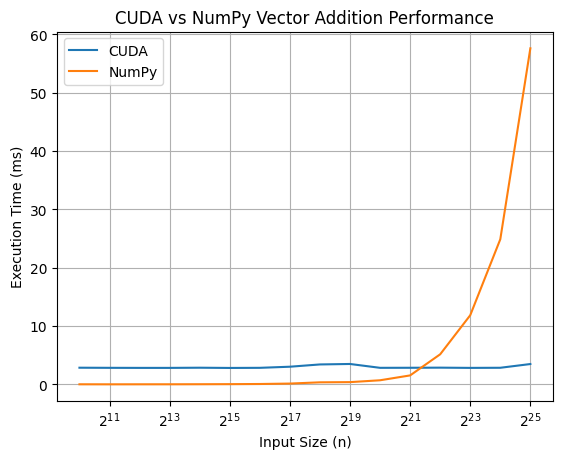

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess

def run_cuda_kernel(n):
    # Compile the CUDA code
    subprocess.run(['nvcc', '-arch=sm_75', 'vector_add.cu', '-o', 'vector_add'], check=True)

    # Run the CUDA executable and capture output
    result = subprocess.run(['./vector_add'], capture_output=True, text=True)

    # Extract GPU time from output
    output_lines = result.stdout.split('\n')
    gpu_time_line = [line for line in output_lines if line.startswith('GPU Time:')][0]
    gpu_time = float(gpu_time_line.split(':')[1].strip().split(' ')[0])

    return gpu_time

def run_numpy(n):
    a = np.random.rand(n).astype(np.float32)
    b = np.random.rand(n).astype(np.float32)

    start = time.time()
    c_cpu = a + b
    cpu_time = (time.time() - start) * 1000  # Convert to milliseconds

    return cpu_time

# Define range of input sizes
n_values = [1 << i for i in range(10, 26)]  # Powers of 2 from 2^10 to 2^25

# Run experiments and store results
cuda_times = []
numpy_times = []

for n in n_values:
    cuda_times.append(run_cuda_kernel(n))
    numpy_times.append(run_numpy(n))

# Plot the results
plt.plot(n_values, cuda_times, label='CUDA')
plt.plot(n_values, numpy_times, label='NumPy')
plt.xscale('log', base=2)
plt.xlabel('Input Size (n)')
plt.ylabel('Execution Time (ms)')
plt.title('CUDA vs NumPy Vector Addition Performance')
plt.legend()
plt.grid(True)
plt.show()